# Predicting bank's customer response

Banks strive to increase the efficiency of their contacts with customers. One of the areas which require this is offering new products to existing clients (cross-selling). Instead of offering new products to all clients, it is a good idea to predict the probability of a positive response. Then the offers could be sent to those clients, for whom the probability of response is higher than some threshold value.

In this notebook I try to solve this problem. In 2011 OTP-Bank in Russia has organized a competition reflecting the aforementioned situation. The data is taken from that [site](http://machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29).
The competition's description and some data is in Russian, but I'll translate the necessary termins. Column names are already in English.

Dataset contains 15223 clients; 1812 of them had a positive response. I can't use test set, as competition is finished and quality of predictions on test data can't be verified. So I can only split data in train and test and check the accuracy this way.

The metric for the competition is AUC (area under curve). The winner achieved 0,6935, top-7 places have AUC higher than 0,67.

I don't aim to beat these values, my goal is to explore and visualize the data. Also I want to show how to process the data and make predictions so that model is stable and can be interpreted.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn import linear_model
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import functions

%load_ext autoreload
%autoreload 2

### Data loading and initial preprocessing

In [2]:
%%time
data = pd.read_excel('data set.xls', sheetname='данные')

Wall time: 6.37 s


I'll rename values for several columns first of all, and I'll drop some unnecessary columns.

In [3]:
data.loc[data['EDUCATION'] == 'Среднее специальное', 'EDUCATION'] = 'Professional School'
data.loc[data['EDUCATION'] == 'Среднее', 'EDUCATION'] = 'Some High School'
data.loc[data['EDUCATION'] == 'Неполное среднее', 'EDUCATION'] = 'Some Primary School'
data.loc[data['EDUCATION'] == 'Высшее', 'EDUCATION'] = 'Undergraduate Degree'
data.loc[data['EDUCATION'] == 'Неоконченное высшее', 'EDUCATION'] = 'No Formal Education'
data.loc[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Post-Graduate Work'
data.loc[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Graduate Degree'

In [4]:
data.loc[data['MARITAL_STATUS'] == 'Состою в браке', 'MARITAL_STATUS'] = 'Married'
data.loc[data['MARITAL_STATUS'] == 'Гражданский брак', 'MARITAL_STATUS'] = 'Partner'
data.loc[data['MARITAL_STATUS'] == 'Разведен(а)', 'MARITAL_STATUS'] = 'Separated'
data.loc[data['MARITAL_STATUS'] == 'Не состоял в браке', 'MARITAL_STATUS'] = 'Single'
data.loc[data['MARITAL_STATUS'] == 'Вдовец/Вдова', 'MARITAL_STATUS'] = 'Widowed'

In [5]:
data.loc[data['GEN_INDUSTRY'] == 'Металлургия/Промышленность/Машиностроение', 'GEN_INDUSTRY'] = 'Iron & Steel'
data.loc[data['GEN_INDUSTRY'] == 'Строительство', 'GEN_INDUSTRY'] = 'Construction - Raw Materials'
data.loc[data['GEN_INDUSTRY'] == 'Нефтегазовая промышленность', 'GEN_INDUSTRY'] = 'Oil & Gas Operations'
data.loc[data['GEN_INDUSTRY'] == 'Энергетика', 'GEN_INDUSTRY'] = 'Oil Well Services & Equipment'
data.loc[data['GEN_INDUSTRY'] == 'Страхование', 'GEN_INDUSTRY'] = 'Insurance (Accident & Health)'
data.loc[data['GEN_INDUSTRY'] == 'Банк/Финансы', 'GEN_INDUSTRY'] = 'Regional Banks'
data.loc[data['GEN_INDUSTRY'] == 'Здравоохранение', 'GEN_INDUSTRY'] = 'Healthcare'
data.loc[data['GEN_INDUSTRY'] == 'Управляющая компания', 'GEN_INDUSTRY'] = 'Business Services'
data.loc[data['GEN_INDUSTRY'] == 'Туризм', 'GEN_INDUSTRY'] = 'Hotels & Motels'
data.loc[data['GEN_INDUSTRY'] == 'Юридические услуги/нотариальные услуги', 'GEN_INDUSTRY'] = 'Personal Services'
data.loc[data['GEN_INDUSTRY'] == 'Недвижимость', 'GEN_INDUSTRY'] = 'Real Estate Operations'
data.loc[data['GEN_INDUSTRY'] == 'Развлечения/Искусство', 'GEN_INDUSTRY'] = 'Recreational Activities'
data.loc[data['GEN_INDUSTRY'] == 'Ресторанный бизнес /общественное питание', 'GEN_INDUSTRY'] = 'Restaurants'
data.loc[data['GEN_INDUSTRY'] == 'Образование', 'GEN_INDUSTRY'] = 'Schools'
data.loc[data['GEN_INDUSTRY'] == 'Наука', 'GEN_INDUSTRY'] = 'Scientific & Technical Instr.'
data.loc[data['GEN_INDUSTRY'] == 'Информационные технологии', 'GEN_INDUSTRY'] = 'Software & Programming'
data.loc[data['GEN_INDUSTRY'] == 'Транспорт', 'GEN_INDUSTRY'] = 'Transportation'
data.loc[data['GEN_INDUSTRY'] == 'Логистика', 'GEN_INDUSTRY'] = 'Trucking'
data.loc[data['GEN_INDUSTRY'] == 'Ресторанный бизнес/Общественное питание', 'GEN_INDUSTRY'] = 'Restaurant & Catering'
data.loc[data['GEN_INDUSTRY'] == 'Коммунальное хоз-во/Дорожные службы', 'GEN_INDUSTRY'] = 'Municipal economy/Road service'
data.loc[data['GEN_INDUSTRY'] == 'Салоны красоты и здоровья', 'GEN_INDUSTRY'] = 'Beauty shop'
data.loc[data['GEN_INDUSTRY'] == 'Сборочные производства', 'GEN_INDUSTRY'] = 'Assembly production'
data.loc[data['GEN_INDUSTRY'] == 'Сельское хозяйство', 'GEN_INDUSTRY'] = 'Agriculture'
data.loc[data['GEN_INDUSTRY'] == 'Химия/Парфюмерия/Фармацевтика', 'GEN_INDUSTRY'] = 'Chemistry/Perfumery/Pharmaceut'
data.loc[data['GEN_INDUSTRY'] == 'ЧОП/Детективная д-ть', 'GEN_INDUSTRY'] = 'Detective'
data.loc[data['GEN_INDUSTRY'] == 'Другие сферы', 'GEN_INDUSTRY'] = 'Others fields'
data.loc[data['GEN_INDUSTRY'] == 'Государственная служба', 'GEN_INDUSTRY'] = 'Public  & municipal administ.'
data.loc[data['GEN_INDUSTRY'] == 'Информационные услуги', 'GEN_INDUSTRY'] = 'Information service'
data.loc[data['GEN_INDUSTRY'] == 'Торговля', 'GEN_INDUSTRY'] = 'Market, real estate'
data.loc[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'Marketing'
data.loc[data['GEN_INDUSTRY'] == 'Подбор персонала', 'GEN_INDUSTRY'] = 'Staff recruitment'
data.loc[data['GEN_INDUSTRY'] == 'СМИ/Реклама/PR-агенства', 'GEN_INDUSTRY'] = 'Mass media'

In [6]:
data.loc[data['FAMILY_INCOME'] == 'от 10000 до 20000 руб.', 'FAMILY_INCOME'] = '10000-20000'
data.loc[data['FAMILY_INCOME'] == 'от 20000 до 50000 руб.', 'FAMILY_INCOME'] = '20000-50000'
data.loc[data['FAMILY_INCOME'] == 'от 5000 до 10000 руб.', 'FAMILY_INCOME'] = '5000-10000'
data.loc[data['FAMILY_INCOME'] == 'свыше 50000 руб.', 'FAMILY_INCOME'] = '50000+'
data.loc[data['FAMILY_INCOME'] == 'до 5000 руб.', 'FAMILY_INCOME'] = 'up to 5000'

In [7]:
data.drop(['GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR', 'REG_ADDRESS_PROVINCE',
           'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE', 'REGION_NM'], axis=1, inplace=True)

In [8]:
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,FAMILY_INCOME,PERSONAL_INCOME,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Professional School,Married,"Market, real estate",10000-20000,5000.0,1,1,1,1,1,0,0,0,0,0,0,0,8000.00,6,8650.0,0,1,220,18.0,0,0,1,1,1,6,2,1,1580.000000,1580.0,NaN
1,59910230,0,32,1,0,1,3,3,Some High School,Married,"Market, real estate",10000-20000,12000.0,1,1,1,1,0,0,0,0,0,0,0,0,21650.00,6,4000.0,0,1,137,97.0,1,0,1,1,1,6,1,1,4020.000000,4020.0,NaN
2,59910525,0,52,1,0,1,4,0,Some Primary School,Married,Software & Programming,10000-20000,9000.0,1,1,1,1,1,0,0,0,1,0,0,0,33126.00,12,4000.0,0,1,251,84.0,0,0,1,2,1,11,0,0,0.000000,0.0,NaN
3,59910803,0,39,1,0,1,1,1,Undergraduate Degree,Married,Schools,20000-50000,25000.0,0,1,0,0,1,1,0,0,0,0,0,0,8491.82,6,5000.0,0,0,36,168.0,1,1,1,1,1,6,3,1,1589.923333,1590.0,NaN
4,59911781,0,30,1,0,0,0,0,Some High School,Married,Public & municipal administ.,10000-20000,12000.0,1,1,1,1,0,0,0,0,1,0,0,0,21990.00,12,4000.0,0,1,83,101.0,1,0,1,2,1,16,2,1,1152.150000,2230.0,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 43 columns):
AGREEMENT_RK                  15223 non-null int64
TARGET                        15223 non-null int64
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null int64
SOCSTATUS_PENS_FL             15223 non-null int64
GENDER                        15223 non-null int64
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  13856 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_FACT_FL                   15223 non-null int64
FACT_POST_FL                  15223 non-null int64
REG_POST_FL                   15223 non-null int64
REG_FACT_POST_FL              15223 non-null int64
REG_FACT_POST_TP_F

This is how the data looks like. 43 columns and several of them have missing values.
I'll do the following things:

* drop several columns, where one of the values is too prevalent (has 95% or more). This is an arbitrary value and can be changed. The reason to do this is that if other categories in the variable have less that 5% in total and the target has ~11% positive response, than the variable will be hardly useful. Of course, maybe one of less common classes always has positive response (this needs to be checkes), in this case the feature should be used;
* process continuous variables;
* process categorical variables;
* select variables and build the model;

In [10]:
for col in data.columns:
    if data[col].value_counts(dropna=False, normalize=True).values[0] > 0.95:
        if col == 'TARGET':
            pass
        else:
            print(col)
            data.drop([col], axis=1, inplace=True)

FACT_POST_FL
COT_PRESENCE_FL
GAR_PRESENCE_FL
LAND_PRESENCE_FL
DL_DOCUMENT_FL
PREVIOUS_CARD_NUM_UTILIZED


## Continuous

It is worth noticing that often it makes sense to create new variables from the ones already existing. While separate variables can have some impact on the model performance, their interaction may bring much more value. As an example I create a new variable as the value of income divided by the credit amount. If credit amount is much higher than income, there could be problems in paying it, if credit is many times lower, it could be of little interest to the customer. Of course, the dependences are more difficults, but you get the gist.

In [11]:
data['Income_to_limit'] = data['PERSONAL_INCOME'] / data['CREDIT']

And now there is a question about what to do with continuous variables. Usually I use them as they are, or use some kind of transformation (for example log) if necessary or normalize the values. But if the model needs to be interpretable, this won't do. The model should show how certain values impact the probability of positive response. So I'll split continuous variables into bins, so that each variable will have a separate coefficient in the model. I have written the function **split_best_iv** for this in [this file](https://github.com/Erlemar/Erlemar.github.io/blob/master/Notebooks/functions.py). It splits the continuous variable into bins to maximize IV (Information Value).

What is IV? In fact it was and still is widely used in bank analysis. In simple terms it shows how useful is the variable for predicting the target. It is calculated in the following way (you can see an example below for "GENDER"):
* For each category % of responders is calculated - how many people in the category have positive class;
* The same is calculated for negative class;
* WOE (Weight of Evidence) is calculated as logarithm of responders rate divided by non-resonders rate. WOE shows how good is the category in separating positive and negative outcomes. Also negative WOE shows that there are more non-responders, positive implies more responders;
* Difference between distributions of positive and negative incomes is calculated;
* IV for each category is a multiplication of the aforementioned difference and WOE;
* IV for the variable is the sum of IV for each category;

Rule of thumb for IV is the following:
* < 0.02 - feature isn't useful for prediction;
* 0.02 - 0.1 - weak impact on prediction quality;
* 0.1 - 0.3 - medium impact;
* 0.3 - 0.5 - strong impact;
* 0.5+ - may cause overfitting;

These aren't definite thesholds, but we should pay attention to them.

In [12]:
df = pd.DataFrame(index = data['GENDER'].unique(),
                      data={'% responders': data.groupby('GENDER')['TARGET'].sum() / np.sum(data['TARGET'])})
df['% non-responders'] = (data.groupby('GENDER')['TARGET'].count() - data.groupby('GENDER')['TARGET'].sum()) \
                        / (len(data['TARGET']) - np.sum(data['TARGET']))
df['WOE'] = np.log(df['% responders'] / df['% non-responders'])
df['DG-DB'] = df['% responders'] - df['% non-responders']
df['IV'] = df['WOE'] * df['DG-DB']
df
print('IV is {:.2f}.'.format(np.sum(df['IV'])))

IV is 0.01.


Back to the function. Function **split_best_iv** calls function **cont_split**, which tries to split the variable into bins. I use DecisionTreeClassifier for this, which is really great for the purpose. Interesting parameters:
* criterion='entropy': to maximize information gain while branching trees;
* min_samples_split=0.05, min_samples_leaf=0.05: so that there are at least 5% values in each category. The reasons for choosing this value were mentioned higher;
* class_weight='balanced': great option for working with unbalanced classes;
* max_leaf_nodes=leafs: how many categories will be created, more about this lower;

After this I use **tree_to_thresholds** function to walk the tree and gather the thresholds for the decision rules. The code was adopted from [this](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree) stackoverflow question. I round values, as having fractional age for example makes little sense.
Then I calculate and save IV value.
At the beginning there are 2 leafs. Then **split_best_iv** function increases number of leafs until IV stops increasing. This will be the optimal number of leafs and optimal split into the bins. The examples will be lower.

## Outliers

It is very important to deal with outliers. Some of the usual ways are:
* Dropping rows with these values;
* Replacing these values with more reasonable figures;
* Building a separate model for them;

I'll go with the first choice.

To identify outliers I use either boxplots or simply look at the top values.

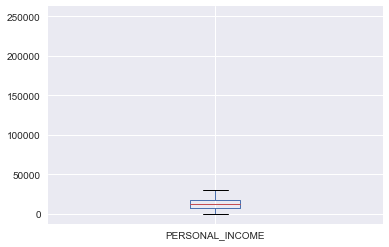

In [13]:
data['PERSONAL_INCOME'].plot(kind='box')

Boxplot shows that while median value is reasonable, max values are very high. In fact it is necessary to investigate whether these values are normal. Maybe they are VIP clients, maybe there is an error in the data, maybe this is completely normal or there could be some other reason. I have no additional data, so I'll just get rid of top-1% and low-1%.

In [14]:
data = data[(data.PERSONAL_INCOME < np.percentile(data.PERSONAL_INCOME, 99))
            & (data.PERSONAL_INCOME > np.percentile(data.PERSONAL_INCOME, 1))]

In [15]:
data['WORK_TIME'].nlargest(20)

8984     2867959.0
4296       10000.0
2532        4320.0
5375        3500.0
9852        1500.0
1092        1312.0
11720       1254.0
13928       1120.0
9983         976.0
10677        864.0
10171        860.0
676          780.0
7711         730.0
3323         612.0
2983         600.0
8864         540.0
4122         528.0
9536         528.0
4571         519.0
1068         516.0
Name: WORK_TIME, dtype: float64

I may believe that people work at the current place for 10, 30, maybe even 50 years. More is quite unlikely. I'll drop these values. There is a possibility to replace these figures with more adequate values, but there is enough data, so dropping is okay.

In [16]:
data.drop([8984, 4296, 2532, 5375, 9852, 1092, 11720, 13928, 9983, 10677, 10171, 676, 7711, 3323], inplace=True)

In [17]:
data['FST_PAYMENT'].nlargest()

4124     140000.0
14367     75606.0
4874      75570.0
4162      75500.0
11300     70940.0
Name: FST_PAYMENT, dtype: float64

In [18]:
data.loc[data['FST_PAYMENT'] > data['CREDIT']][['CREDIT', 'FST_PAYMENT']][:10]
len(data.loc[data['FST_PAYMENT'] > data['CREDIT']][['CREDIT', 'FST_PAYMENT']])

485

We see that there are 485 rows where initial payment is higher than the credit amount. This definitely isn't normal.

In [19]:
data = data.loc[data['FST_PAYMENT'] < data['CREDIT']]

In [20]:
#Living in the place, months.
data['FACT_LIVING_TERM'].nlargest(20)

6186     28101997
12261    16091983
8562        23916
14739        7200
988          6534
12869        6336
7650         3612
12134        3228
5681         3168
11004        2520
14707        1278
12232        1000
5369          980
1420          890
3789          720
5888          720
1937          708
4463          700
4705          696
1013          684
Name: FACT_LIVING_TERM, dtype: int64

While it is possible that people can live in the same place all their life, I don't think that there are many people living for 100+ years :)

In [21]:
data.drop([6186, 12261, 8562, 14739, 988, 12869, 7650, 12134, 5681, 11004, 14707], inplace=True)

In [22]:
data.shape, np.sum(data['TARGET'])

((14276, 38), 1720)

In [23]:
#This will be used lated.
initial_data = data.copy()

947 values were dropped, but only 92 of them had positive response. 

### PERSONAL_INCOME

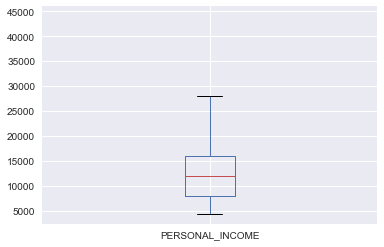

In [24]:
data['PERSONAL_INCOME'].plot(kind='box')

It is time to try splitting the variable.

In [25]:
data['PERSONAL_INCOME'] = functions.split_best_iv(data, 'PERSONAL_INCOME', 'TARGET')

(0.0, 7600.0]         0.180513
(9300.0, 11000.0]     0.161600
(15300.0, 20800.0]    0.151863
(11000.0, 14800.0]    0.140866
(7600.0, 9300.0]      0.131690
(20800.0, 44000.0]    0.118941
(14800.0, 15300.0]    0.114528
Name: PERSONAL_INCOME, dtype: float64
IV:  0.0910365540526


Done, and there are two more functions. Second one was already used, it caculates IV. The first one shows the following things:
* Counts of each category;
* Normalized counts including missing values;
* Graph with blue bars for counts and red line for mean value of target (or what percent of values in category have positive income);

Counts:
PERSONAL_INCOME
(0.0, 7600.0]         2577
(7600.0, 9300.0]      1880
(9300.0, 11000.0]     2307
(11000.0, 14800.0]    2011
(14800.0, 15300.0]    1635
(15300.0, 20800.0]    2168
(20800.0, 44000.0]    1698
Name: TARGET, dtype: int64
Frequencies:
(0.0, 7600.0]         0.180513
(9300.0, 11000.0]     0.161600
(15300.0, 20800.0]    0.151863
(11000.0, 14800.0]    0.140866
(7600.0, 9300.0]      0.131690
(20800.0, 44000.0]    0.118941
(14800.0, 15300.0]    0.114528
Name: PERSONAL_INCOME, dtype: float64


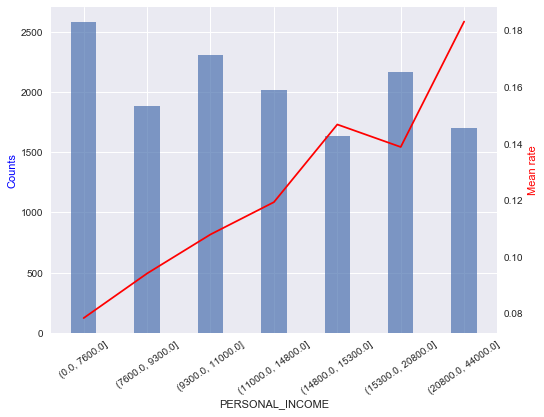

IV:  0.0910365540526


,% responders,% non-responders,WOE,DG-DB,IV
"(11000.0, 14800.0]",0.139535,0.141048,-0.010786,-0.001513,0.000016
"(7600.0, 9300.0]",0.102907,0.135632,-0.276123,-0.032725,0.009036
"(20800.0, 44000.0]",0.180814,0.110465,0.492769,0.070349,0.034666
"(0.0, 7600.0]",0.117442,0.189153,-0.476611,-0.071711,0.034178
"(15300.0, 20800.0]",0.175000,0.148694,0.162896,0.026306,0.004285
"(9300.0, 11000.0]",0.144767,0.163906,-0.124163,-0.019138,0.002376
"(14800.0, 15300.0]",0.139535,0.111102,0.227864,0.028433,0.006479


In [26]:
functions.feature_stat(data, 'PERSONAL_INCOME', 'TARGET')
functions.calc_iv(data, 'TARGET', 'PERSONAL_INCOME')[0]

People with higher income tend to have higher positive response rate.

### Age

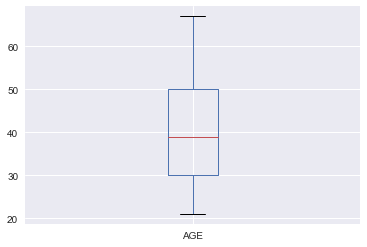

In [27]:
data['AGE'].plot(kind='box')

In [28]:
data['AGE'] = functions.split_best_iv(data, 'AGE', 'TARGET')

(42.0, 50.0]    0.180583
(54.0, 67.0]    0.146820
(0.0, 26.0]     0.135332
(30.0, 34.0]    0.119992
(26.0, 30.0]    0.118170
(34.0, 38.0]    0.108854
(38.0, 42.0]    0.101989
(50.0, 54.0]    0.088260
Name: AGE, dtype: float64
IV:  0.123625857889


Counts:
AGE
(0.0, 26.0]     1932
(26.0, 30.0]    1687
(30.0, 34.0]    1713
(34.0, 38.0]    1554
(38.0, 42.0]    1456
(42.0, 50.0]    2578
(50.0, 54.0]    1260
(54.0, 67.0]    2096
Name: TARGET, dtype: int64
Frequencies:
(42.0, 50.0]    0.180583
(54.0, 67.0]    0.146820
(0.0, 26.0]     0.135332
(30.0, 34.0]    0.119992
(26.0, 30.0]    0.118170
(34.0, 38.0]    0.108854
(38.0, 42.0]    0.101989
(50.0, 54.0]    0.088260
Name: AGE, dtype: float64


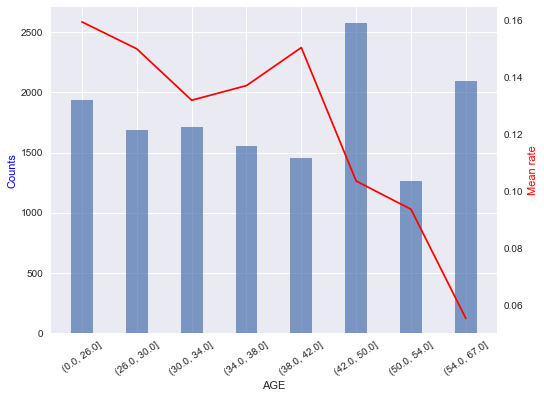

IV:  0.123625857889


,% responders,% non-responders,WOE,DG-DB,IV
"(30.0, 34.0]",0.131395,0.118429,0.103893,0.012966,0.001347
"(50.0, 54.0]",0.068605,0.090953,-0.281977,-0.022348,0.006302
"(38.0, 42.0]",0.127326,0.098519,0.256502,0.028807,0.007389
"(26.0, 30.0]",0.147093,0.114208,0.253041,0.032885,0.008321
"(42.0, 50.0]",0.155233,0.184055,-0.170313,-0.028823,0.004909
"(0.0, 26.0]",0.179070,0.129341,0.325327,0.049729,0.016178
"(54.0, 67.0]",0.067442,0.157694,-0.849388,-0.090252,0.076659
"(34.0, 38.0]",0.123837,0.106802,0.147996,0.017036,0.002521


In [29]:
functions.feature_stat(data, 'AGE', 'TARGET')
functions.calc_iv(data, 'TARGET', 'AGE')[0]

Younger people take more credits, while only a fraction of elder people have positive response.

### WORK_TIME

Time of work on the current workplace in months.

In [30]:
#I assume that missing values mean that the person didn't work at all.
data['WORK_TIME'].fillna(0, inplace=True)

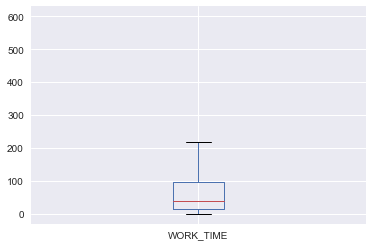

In [31]:
data['WORK_TIME'].plot(kind='box')

Here I add another line. If variable has zero values, DecisionTreeClassifier has problems with it. I combine zero values with the nearest interval.

In [32]:
data['WORK_TIME'] = functions.split_best_iv(data, 'WORK_TIME', 'TARGET')
data['WORK_TIME'].fillna(data['WORK_TIME'].cat.categories[0], inplace=True)

(35.5, 53.5]      0.164122
(151.0, 600.0]    0.158238
(6.5, 21.5]       0.156276
(53.5, 85.5]      0.149902
(85.5, 151.0]     0.119011
(21.5, 35.5]      0.109344
NaN               0.086579
(0.0, 6.5]        0.056528
Name: WORK_TIME, dtype: float64
IV:  0.075887395125


Counts:
WORK_TIME
(0.0, 6.5]        2043
(6.5, 21.5]       2231
(21.5, 35.5]      1561
(35.5, 53.5]      2343
(53.5, 85.5]      2140
(85.5, 151.0]     1699
(151.0, 600.0]    2259
Name: TARGET, dtype: int64
Frequencies:
(35.5, 53.5]      0.164122
(151.0, 600.0]    0.158238
(6.5, 21.5]       0.156276
(53.5, 85.5]      0.149902
(0.0, 6.5]        0.143107
(85.5, 151.0]     0.119011
(21.5, 35.5]      0.109344
Name: WORK_TIME, dtype: float64


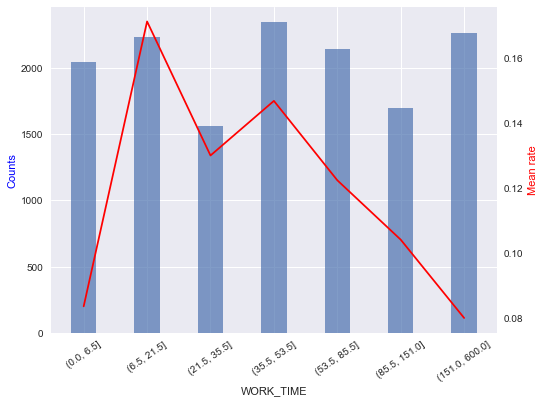

IV:  0.0913808898649


,% responders,% non-responders,WOE,DG-DB,IV
"(85.5, 151.0]",0.102907,0.121217,-0.163756,-0.018310,0.002998
"(53.5, 85.5]",0.152326,0.149570,0.018256,0.002756,0.000050
"(151.0, 600.0]",0.105233,0.165499,-0.452790,-0.060266,0.027288
"(35.5, 53.5]",0.200000,0.159207,0.228114,0.040793,0.009305
"(0.0, 6.5]",0.099419,0.149092,-0.405225,-0.049673,0.020129
"(21.5, 35.5]",0.118023,0.108155,0.087312,0.009868,0.000862
"(6.5, 21.5]",0.222093,0.147260,0.410895,0.074833,0.030748


In [33]:
functions.feature_stat(data, 'WORK_TIME', 'TARGET')
functions.calc_iv(data, 'TARGET', 'WORK_TIME')[0]

### CREDIT

Credit amount in roubles.

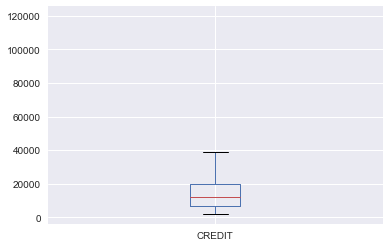

In [34]:
data['CREDIT'].plot(kind='box')

Some of credits have much higher values than median, but maybe these are special kinds of credit, how which these amounts are normal.

In [35]:
data['CREDIT'] = functions.split_best_iv(data, 'CREDIT', 'TARGET')

(9400.0, 14100.0]      0.200897
(22500.0, 119700.0]    0.175960
(0.0, 5400.0]          0.169585
(14100.0, 18100.0]     0.127487
(5400.0, 7200.0]       0.116629
(18100.0, 22500.0]     0.110325
(7200.0, 9400.0]       0.099117
Name: CREDIT, dtype: float64
IV:  0.0155129903385


Counts:
CREDIT
(0.0, 5400.0]          2421
(5400.0, 7200.0]       1665
(7200.0, 9400.0]       1415
(9400.0, 14100.0]      2868
(14100.0, 18100.0]     1820
(18100.0, 22500.0]     1575
(22500.0, 119700.0]    2512
Name: TARGET, dtype: int64
Frequencies:
(9400.0, 14100.0]      0.200897
(22500.0, 119700.0]    0.175960
(0.0, 5400.0]          0.169585
(14100.0, 18100.0]     0.127487
(5400.0, 7200.0]       0.116629
(18100.0, 22500.0]     0.110325
(7200.0, 9400.0]       0.099117
Name: CREDIT, dtype: float64


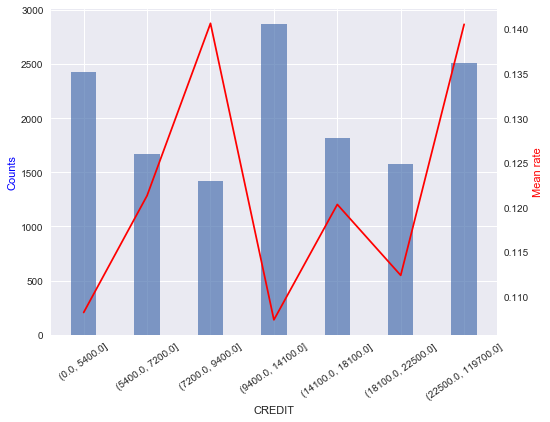

IV:  0.0155129903385


,% responders,% non-responders,WOE,DG-DB,IV
"(18100.0, 22500.0]",0.102907,0.111341,-0.078774,-0.008434,6.643955e-04
"(22500.0, 119700.0]",0.205233,0.171950,0.176942,0.033283,5.889141e-03
"(7200.0, 9400.0]",0.115698,0.096846,0.177857,0.018852,3.352881e-03
"(14100.0, 18100.0]",0.127326,0.127509,-0.001438,-0.000183,2.633451e-07
"(0.0, 5400.0]",0.152326,0.171950,-0.121182,-0.019624,2.378077e-03
"(9400.0, 14100.0]",0.179070,0.203887,-0.129788,-0.024817,3.220936e-03
"(5400.0, 7200.0]",0.117442,0.116518,0.007898,0.000924,7.296327e-06


In [36]:
functions.feature_stat(data, 'CREDIT', 'TARGET')
functions.calc_iv(data, 'TARGET', 'CREDIT')[0]

### TERM

Credit length. I think in months.

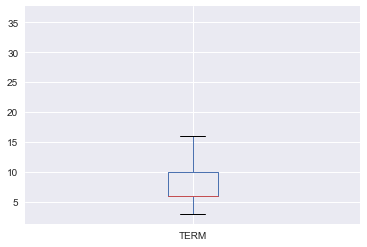

In [37]:
data['TERM'].plot(kind='box')

In [38]:
data['TERM'] = functions.split_best_iv(data, 'TERM', 'TARGET')

(4.5, 8.5]      0.410759
(11.5, 36.0]    0.241454
(8.5, 11.5]     0.209793
(0.0, 4.5]      0.137994
Name: TERM, dtype: float64
IV:  0.032100382616


Counts:
TERM
(0.0, 4.5]      1970
(4.5, 8.5]      5864
(8.5, 11.5]     2995
(11.5, 36.0]    3447
Name: TARGET, dtype: int64
Frequencies:
(4.5, 8.5]      0.410759
(11.5, 36.0]    0.241454
(8.5, 11.5]     0.209793
(0.0, 4.5]      0.137994
Name: TERM, dtype: float64


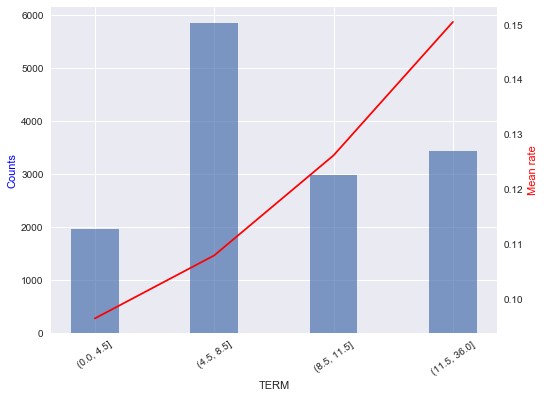

IV:  0.032100382616


,% responders,% non-responders,WOE,DG-DB,IV
"(4.5, 8.5]",0.368023,0.416614,-0.124013,-0.048590,0.006026
"(11.5, 36.0]",0.301744,0.233195,0.257703,0.068549,0.017665
"(8.5, 11.5]",0.219767,0.208426,0.052985,0.011341,0.000601
"(0.0, 4.5]",0.110465,0.141765,-0.249470,-0.031300,0.007808


In [39]:
functions.feature_stat(data, 'TERM', 'TARGET')
functions.calc_iv(data, 'TARGET', 'TERM')[0]

### FST_PAYMENT

Initial fee amount in roubles

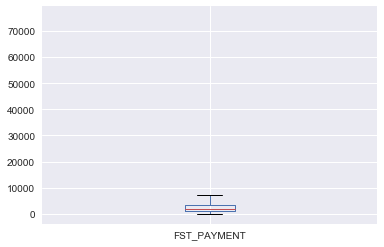

In [40]:
data['FST_PAYMENT'].plot(kind='box')

In [41]:
data['FST_PAYMENT'] = functions.split_best_iv(data, 'FST_PAYMENT', 'TARGET')
data['FST_PAYMENT'].fillna(data['FST_PAYMENT'].cat.categories[0], inplace=True)

(2100.0, 3800.0]     0.195853
(200.0, 900.0]       0.145139
(3800.0, 6000.0]     0.134071
(900.0, 1200.0]      0.118801
(1700.0, 2100.0]     0.115158
(1200.0, 1700.0]     0.105492
(6000.0, 75600.0]    0.099958
NaN                  0.082726
(0.0, 200.0]         0.002802
Name: FST_PAYMENT, dtype: float64
IV:  0.025642074029


Counts:
FST_PAYMENT
(0.0, 200.0]         1221
(200.0, 900.0]       2072
(900.0, 1200.0]      1696
(1200.0, 1700.0]     1506
(1700.0, 2100.0]     1644
(2100.0, 3800.0]     2796
(3800.0, 6000.0]     1914
(6000.0, 75600.0]    1427
Name: TARGET, dtype: int64
Frequencies:
(2100.0, 3800.0]     0.195853
(200.0, 900.0]       0.145139
(3800.0, 6000.0]     0.134071
(900.0, 1200.0]      0.118801
(1700.0, 2100.0]     0.115158
(1200.0, 1700.0]     0.105492
(6000.0, 75600.0]    0.099958
(0.0, 200.0]         0.085528
Name: FST_PAYMENT, dtype: float64


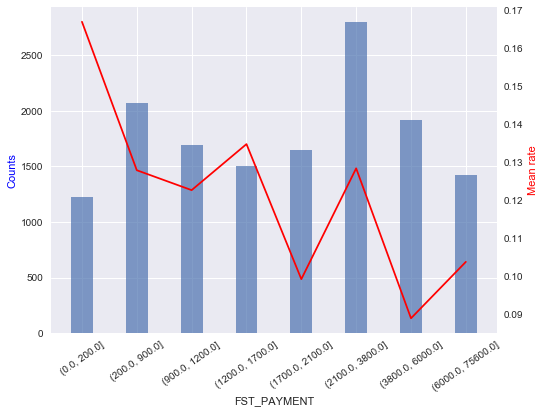

IV:  0.039354549526


,% responders,% non-responders,WOE,DG-DB,IV
"(3800.0, 6000.0]",0.098837,0.138898,-0.340264,-0.040061,0.013631
"(2100.0, 3800.0]",0.208721,0.194090,0.072674,0.014630,0.001063
"(200.0, 900.0]",0.154070,0.143915,0.068181,0.010155,0.000692
"(6000.0, 75600.0]",0.086047,0.101864,-0.168747,-0.015817,0.002669
"(900.0, 1200.0]",0.120930,0.118509,0.020224,0.002421,0.000049
"(1200.0, 1700.0]",0.118023,0.103775,0.128656,0.014248,0.001833
"(1700.0, 2100.0]",0.094767,0.117952,-0.218848,-0.023184,0.005074
"(0.0, 200.0]",0.118605,0.080997,0.381382,0.037608,0.014343


In [42]:
functions.feature_stat(data, 'FST_PAYMENT', 'TARGET')
functions.calc_iv(data, 'TARGET', 'FST_PAYMENT')[0]

### FACT_LIVING_TERM
How long the person lives in the fact place, months.

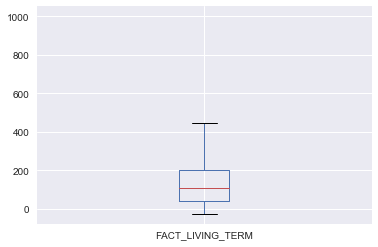

In [43]:
data['FACT_LIVING_TERM'].plot(kind='box')

In [44]:
data['FACT_LIVING_TERM'] = functions.split_best_iv(data, 'FACT_LIVING_TERM', 'TARGET')
data['FACT_LIVING_TERM'].fillna(data['FACT_LIVING_TERM'].cat.categories[0], inplace=True)

(38.5, 85.5]       0.188218
(238.5, 1000.0]    0.187237
(85.5, 131.5]      0.157677
(0.0, 18.5]        0.122373
(18.5, 38.5]       0.122233
(171.5, 238.5]     0.119081
(131.5, 171.5]     0.101919
NaN                0.001261
Name: FACT_LIVING_TERM, dtype: float64
IV:  0.0508487769524


Counts:
FACT_LIVING_TERM
(0.0, 18.5]        1765
(18.5, 38.5]       1745
(38.5, 85.5]       2687
(85.5, 131.5]      2251
(131.5, 171.5]     1455
(171.5, 238.5]     1700
(238.5, 1000.0]    2673
Name: TARGET, dtype: int64
Frequencies:
(38.5, 85.5]       0.188218
(238.5, 1000.0]    0.187237
(85.5, 131.5]      0.157677
(0.0, 18.5]        0.123634
(18.5, 38.5]       0.122233
(171.5, 238.5]     0.119081
(131.5, 171.5]     0.101919
Name: FACT_LIVING_TERM, dtype: float64


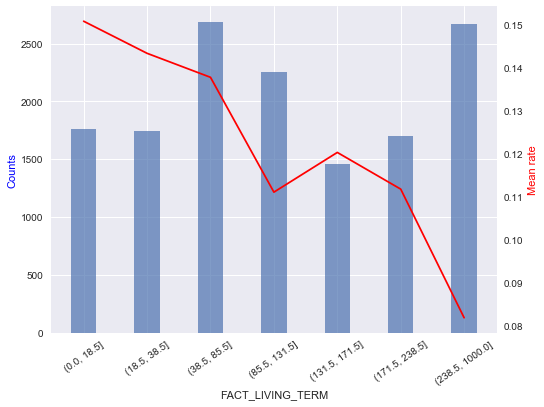

IV:  0.0503735245857


,% responders,% non-responders,WOE,DG-DB,IV
"(131.5, 171.5]",0.101744,0.101943,-0.001955,-0.000199,3.892631e-07
"(238.5, 1000.0]",0.127326,0.195444,-0.428529,-0.068119,2.919086e-02
"(18.5, 38.5]",0.145349,0.119067,0.199454,0.026282,5.242095e-03
"(38.5, 85.5]",0.215116,0.184533,0.153349,0.030583,4.689865e-03
"(85.5, 131.5]",0.145349,0.159366,-0.092067,-0.014017,1.290523e-03
"(171.5, 238.5]",0.110465,0.120261,-0.084967,-0.009796,8.323416e-04
"(0.0, 18.5]",0.154651,0.119385,0.258817,0.035266,9.127448e-03


In [45]:
functions.feature_stat(data, 'FACT_LIVING_TERM', 'TARGET')
functions.calc_iv(data, 'TARGET', 'FACT_LIVING_TERM')[0]

### LOAN_NUM_PAYM

Number of payments by the client

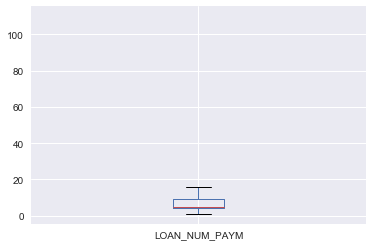

In [46]:
data['LOAN_NUM_PAYM'].plot(kind='box')

In [47]:
data['LOAN_NUM_PAYM'] = functions.split_best_iv(data, 'LOAN_NUM_PAYM', 'TARGET')

(3.5, 4.5]       0.264290
(11.5, 110.0]    0.191580
(4.5, 5.5]       0.154245
(0.0, 3.5]       0.150252
(5.5, 6.5]       0.134351
(6.5, 11.5]      0.105282
Name: LOAN_NUM_PAYM, dtype: float64
IV:  0.0295041530193


Counts:
LOAN_NUM_PAYM
(0.0, 3.5]       2145
(3.5, 4.5]       3773
(4.5, 5.5]       2202
(5.5, 6.5]       1918
(6.5, 11.5]      1503
(11.5, 110.0]    2735
Name: TARGET, dtype: int64
Frequencies:
(3.5, 4.5]       0.264290
(11.5, 110.0]    0.191580
(4.5, 5.5]       0.154245
(0.0, 3.5]       0.150252
(5.5, 6.5]       0.134351
(6.5, 11.5]      0.105282
Name: LOAN_NUM_PAYM, dtype: float64


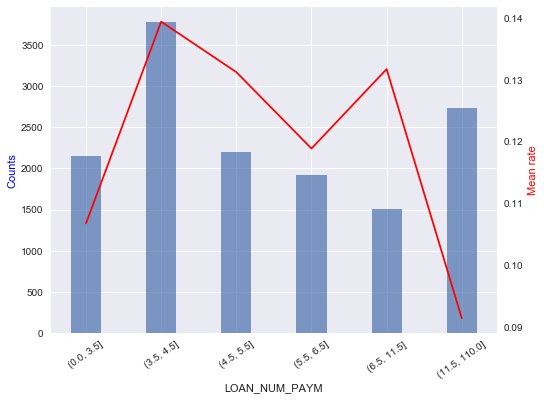

IV:  0.0295041530193


,% responders,% non-responders,WOE,DG-DB,IV
"(5.5, 6.5]",0.132558,0.134597,-0.015264,-0.002039,0.000031
"(6.5, 11.5]",0.115116,0.103934,0.102183,0.011182,0.001143
"(11.5, 110.0]",0.145349,0.197913,-0.308693,-0.052565,0.016226
"(0.0, 3.5]",0.133140,0.152596,-0.136399,-0.019457,0.002654
"(3.5, 4.5]",0.305814,0.258601,0.167689,0.047212,0.007917
"(4.5, 5.5]",0.168023,0.152357,0.097873,0.015666,0.001533


In [48]:
functions.feature_stat(data, 'LOAN_NUM_PAYM', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_NUM_PAYM')[0]

### LOAN_AVG_DLQ_AMT

Average deliquency amount

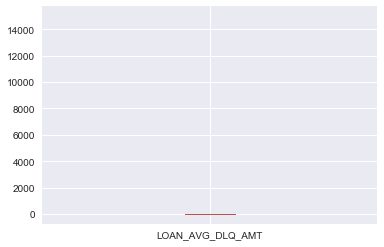

In [49]:
data['LOAN_AVG_DLQ_AMT'].plot(kind='box')

In [50]:
data['LOAN_AVG_DLQ_AMT'] = functions.split_best_iv(data, 'LOAN_AVG_DLQ_AMT', 'TARGET')
data['LOAN_AVG_DLQ_AMT'].fillna(data['LOAN_AVG_DLQ_AMT'].cat.categories[0], inplace=True)

NaN                 0.871603
(500.0, 15000.0]    0.123074
(0.0, 500.0]        0.005324
Name: LOAN_AVG_DLQ_AMT, dtype: float64
IV:  0.0437967491802


Counts:
LOAN_AVG_DLQ_AMT
(0.0, 500.0]        12519
(500.0, 15000.0]     1757
Name: TARGET, dtype: int64
Frequencies:
(0.0, 500.0]        0.876926
(500.0, 15000.0]    0.123074
Name: LOAN_AVG_DLQ_AMT, dtype: float64


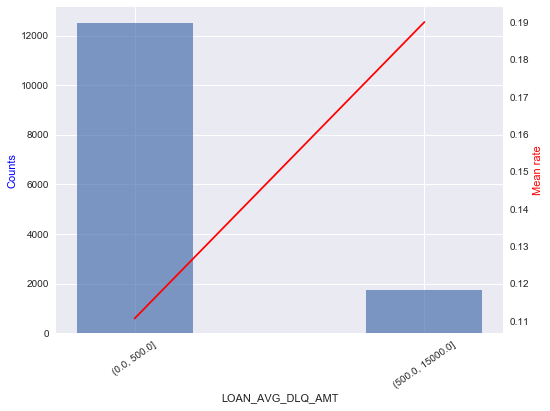

IV:  0.0512702006508


,% responders,% non-responders,WOE,DG-DB,IV
"(500.0, 15000.0]",0.194186,0.113332,0.538493,0.080854,0.043539
"(0.0, 500.0]",0.805814,0.886668,-0.095617,-0.080854,0.007731


In [51]:
functions.feature_stat(data, 'LOAN_AVG_DLQ_AMT', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_AVG_DLQ_AMT')[0]

### LOAN_MAX_DLQ_AMT

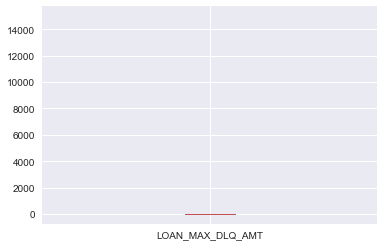

In [52]:
data['LOAN_MAX_DLQ_AMT'].plot(kind='box')

In [53]:
data['LOAN_MAX_DLQ_AMT'] = functions.split_best_iv(data, 'LOAN_MAX_DLQ_AMT', 'TARGET')
data['LOAN_MAX_DLQ_AMT'].fillna(data['LOAN_MAX_DLQ_AMT'].cat.categories[0], inplace=True)

NaN                 0.871603
(500.0, 15000.0]    0.123354
(0.0, 500.0]        0.005043
Name: LOAN_MAX_DLQ_AMT, dtype: float64
IV:  0.0435641041626


Counts:
LOAN_MAX_DLQ_AMT
(0.0, 500.0]        12515
(500.0, 15000.0]     1761
Name: TARGET, dtype: int64
Frequencies:
(0.0, 500.0]        0.876646
(500.0, 15000.0]    0.123354
Name: LOAN_MAX_DLQ_AMT, dtype: float64


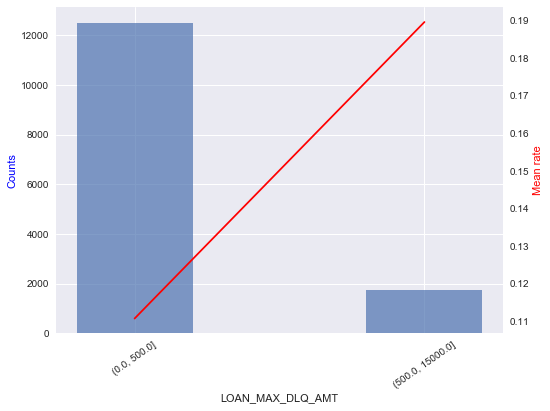

IV:  0.0508131856608


,% responders,% non-responders,WOE,DG-DB,IV
"(500.0, 15000.0]",0.194186,0.113651,0.535686,0.080535,0.043142
"(0.0, 500.0]",0.805814,0.886349,-0.095258,-0.080535,0.007672


In [54]:
functions.feature_stat(data, 'LOAN_MAX_DLQ_AMT', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_MAX_DLQ_AMT')[0]

### Income_to_limit

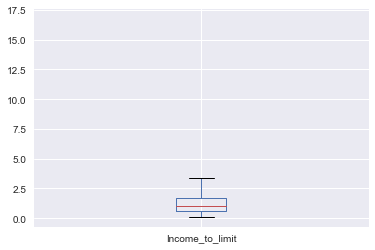

In [55]:
data['Income_to_limit'].plot(kind='box')

In [56]:
data['Income_to_limit'] = functions.split_best_iv(data, 'Income_to_limit', 'TARGET')

(0.515, 0.783]     0.189619
(0.783, 1.108]     0.181704
(0.0, 0.515]       0.174629
(1.428, 1.962]     0.129728
(1.108, 1.428]     0.121393
(2.556, 16.706]    0.114388
(1.962, 2.556]     0.088540
Name: Income_to_limit, dtype: float64
IV:  0.0317804169333


Counts:
Income_to_limit
(0.0, 0.515]       2493
(0.515, 0.783]     2707
(0.783, 1.108]     2594
(1.108, 1.428]     1733
(1.428, 1.962]     1852
(1.962, 2.556]     1264
(2.556, 16.706]    1633
Name: TARGET, dtype: int64
Frequencies:
(0.515, 0.783]     0.189619
(0.783, 1.108]     0.181704
(0.0, 0.515]       0.174629
(1.428, 1.962]     0.129728
(1.108, 1.428]     0.121393
(2.556, 16.706]    0.114388
(1.962, 2.556]     0.088540
Name: Income_to_limit, dtype: float64


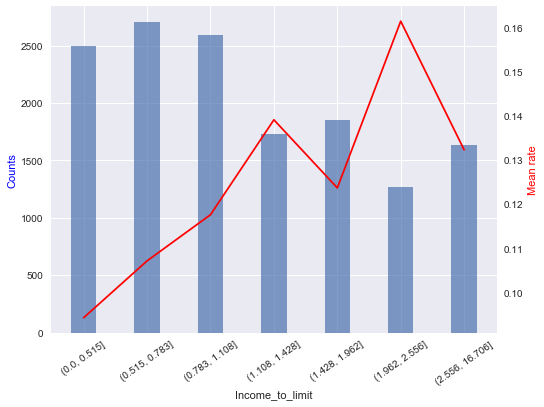

IV:  0.0317804169333


,% responders,% non-responders,WOE,DG-DB,IV
"(0.515, 0.783]",0.168605,0.192498,-0.132527,-0.023893,0.003166
"(0.0, 0.515]",0.136628,0.179834,-0.274775,-0.043206,0.011872
"(2.556, 16.706]",0.125581,0.112854,0.106856,0.012727,0.001360
"(1.428, 1.962]",0.133140,0.129261,0.029565,0.003879,0.000115
"(1.962, 2.556]",0.118605,0.084422,0.339970,0.034183,0.011621
"(1.108, 1.428]",0.140116,0.118828,0.164799,0.021289,0.003508
"(0.783, 1.108]",0.177326,0.182303,-0.027684,-0.004978,0.000138


In [57]:
functions.feature_stat(data, 'Income_to_limit', 'TARGET')
functions.calc_iv(data, 'TARGET', 'Income_to_limit')[0]

## Categorical

Now categorical variables are different. Usually the main problem is that some categories have too little values. Again I'll try to do so that there are no categories with less than 5%. Most of the time it is necessary to combine categories based on the common or business case. I convert variables into type "category" for easier processing. Missing values are treated as a separate category.

In [58]:
for col in ['GENDER', 'CHILD_TOTAL', 'DEPENDANTS', 'EDUCATION', 'MARITAL_STATUS', 'GEN_INDUSTRY', 'OWN_AUTO',
            'FAMILY_INCOME', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM', 'LOAN_MAX_DLQ']:
    data[col] = data[col].astype('category')
    if (data[col].isnull() == True).any():
        data[col].cat.add_categories(['Unknown'], inplace=True)
        data[col].fillna('Unknown', inplace=True)

### OWN_AUTO

Number of cars owned.

In [59]:
data['OWN_AUTO'].value_counts(dropna=False, normalize=True)

0    0.885262
1    0.114668
2    0.000070
Name: OWN_AUTO, dtype: float64

In [60]:
data.loc[data['OWN_AUTO'] == 2, 'OWN_AUTO'] = 1
data['OWN_AUTO'] = data['OWN_AUTO'].cat.remove_unused_categories()

Counts:
OWN_AUTO
0    12638
1     1638
Name: TARGET, dtype: int64
Frequencies:
0    0.885262
1    0.114738
Name: OWN_AUTO, dtype: float64


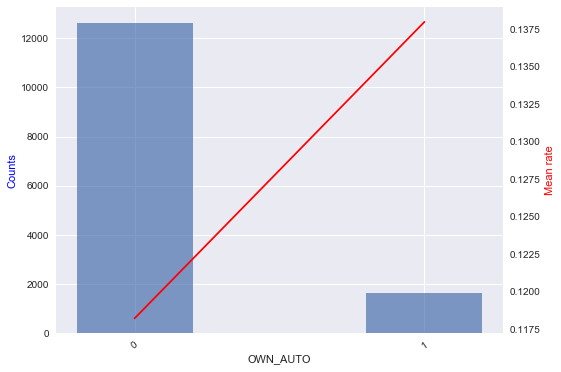

IV:  0.00335633471077


,% responders,% non-responders,WOE,DG-DB,IV
0,0.868605,0.887544,-0.021570,-0.018939,0.000409
1,0.131395,0.112456,0.155647,0.018939,0.002948


In [61]:
functions.feature_stat(data, 'OWN_AUTO', 'TARGET')
functions.calc_iv(data, 'TARGET', 'OWN_AUTO')[0]

## GENDER

Counts:
GENDER
0    4936
1    9340
Name: TARGET, dtype: int64
Frequencies:
1    0.654245
0    0.345755
Name: GENDER, dtype: float64


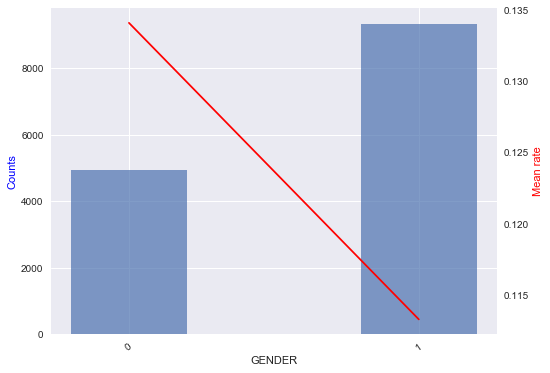

IV:  0.00857138118803


,% responders,% non-responders,WOE,DG-DB,IV
1,0.615116,0.659605,-0.069830,-0.044489,0.003107
0,0.384884,0.340395,0.122834,0.044489,0.005465


In [62]:
functions.feature_stat(data, 'GENDER', 'TARGET')
functions.calc_iv(data, 'TARGET', 'GENDER')[0]

## CHILD_TOTAL

In [63]:
data['CHILD_TOTAL'].value_counts(dropna=False, normalize=True)

1     0.333217
0     0.327473
2     0.272065
3     0.053026
4     0.008826
5     0.003993
6     0.000841
7     0.000350
10    0.000140
8     0.000070
Name: CHILD_TOTAL, dtype: float64

In [64]:
data['CHILD_TOTAL'].cat.add_categories(['3 or more'], inplace=True)
data.loc[data['CHILD_TOTAL'].isin([1.0, 0.0, 2.0]) == False, 'CHILD_TOTAL'] = '3 or more'
data['CHILD_TOTAL'] = data['CHILD_TOTAL'].cat.remove_unused_categories()

Counts:
CHILD_TOTAL
0            4675
1            4757
2            3884
3 or more     960
Name: TARGET, dtype: int64
Frequencies:
1            0.333217
0            0.327473
2            0.272065
3 or more    0.067246
Name: CHILD_TOTAL, dtype: float64


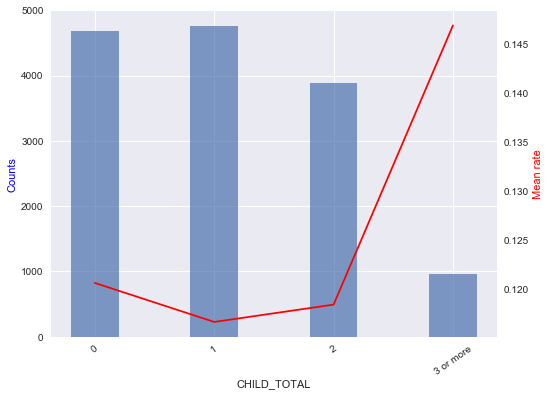

IV:  0.00436821503813


,% responders,% non-responders,WOE,DG-DB,IV
3 or more,0.081977,0.065228,0.228550,0.016749,3.827978e-03
1,0.322674,0.334661,-0.036473,-0.011986,4.371814e-04
0,0.327907,0.327413,0.001507,0.000494,7.441446e-07
2,0.267442,0.272698,-0.019464,-0.005256,1.023110e-04


In [65]:
functions.feature_stat(data, 'CHILD_TOTAL', 'TARGET')
functions.calc_iv(data, 'TARGET', 'CHILD_TOTAL')[0]

## DEPENDANTS

In [66]:
data['DEPENDANTS'].value_counts(dropna=False, normalize=True)

0    0.538386
1    0.297772
2    0.144088
3    0.016251
4    0.002802
5    0.000350
6    0.000280
7    0.000070
Name: DEPENDANTS, dtype: float64

In [67]:
data['DEPENDANTS'].cat.add_categories(['2 or more'], inplace=True)
data.loc[data['DEPENDANTS'].isin([1.0, 2.0]) == False, 'DEPENDANTS'] = '2 or more'
data['DEPENDANTS'] = data['DEPENDANTS'].cat.remove_unused_categories()

Counts:
DEPENDANTS
1            4251
2            2057
2 or more    7968
Name: TARGET, dtype: int64
Frequencies:
2 or more    0.558140
1            0.297772
2            0.144088
Name: DEPENDANTS, dtype: float64


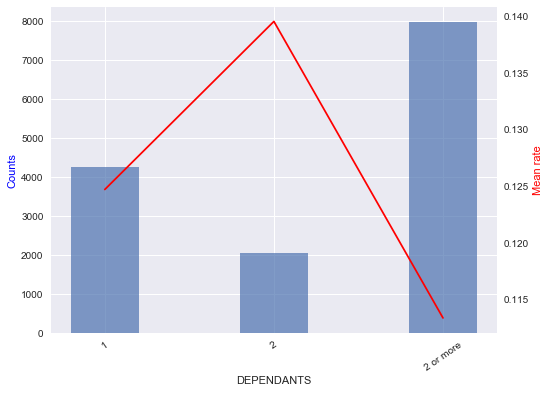

IV:  0.00743729564542


,% responders,% non-responders,WOE,DG-DB,IV
2 or more,0.52500,0.562679,-0.069311,-0.037679,0.002612
1,0.30814,0.296352,0.039004,0.011787,0.000460
2,0.16686,0.140968,0.168622,0.025892,0.004366


In [68]:
functions.feature_stat(data, 'DEPENDANTS', 'TARGET')
functions.calc_iv(data, 'TARGET', 'DEPENDANTS')[0]

## EDUCATION

In [69]:
data['EDUCATION'].value_counts(dropna=False, normalize=True)

Professional School     0.432544
Some High School        0.308700
Undergraduate Degree    0.200406
No Formal Education     0.034744
Some Primary School     0.022345
Post-Graduate Work      0.001191
Graduate Degree         0.000070
Name: EDUCATION, dtype: float64

In [70]:
data.loc[data['EDUCATION'].isin(['Undergraduate Degree', 'Post-Graduate Work', 'Graduate Degree']),
         'EDUCATION'] = 'Undergraduate Degree'
data.loc[data['EDUCATION'].isin(['Some High School', 'No Formal Education', 'Some Primary School']),
         'EDUCATION'] = 'Some High School'
data['EDUCATION'] = data['EDUCATION'].cat.remove_unused_categories()

Counts:
EDUCATION
Professional School     6175
Some High School        5222
Undergraduate Degree    2879
Name: TARGET, dtype: int64
Frequencies:
Professional School     0.432544
Some High School        0.365789
Undergraduate Degree    0.201667
Name: EDUCATION, dtype: float64


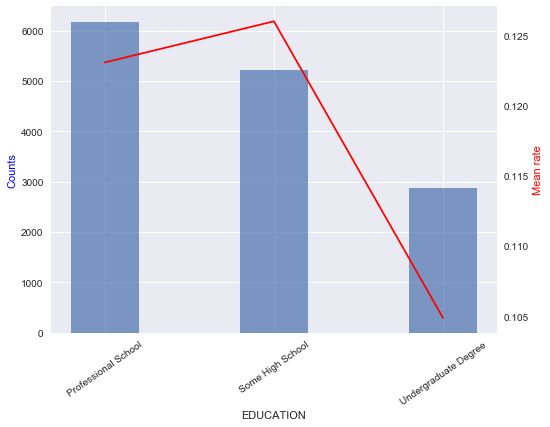

IV:  0.00586098683881


,% responders,% non-responders,WOE,DG-DB,IV
Some High School,0.382558,0.363492,0.051125,0.019067,0.000975
Undergraduate Degree,0.175581,0.205241,-0.156080,-0.029659,0.004629
Professional School,0.441860,0.431268,0.024265,0.010593,0.000257


In [71]:
functions.feature_stat(data, 'EDUCATION', 'TARGET')
functions.calc_iv(data, 'TARGET', 'EDUCATION')[0]

## MARITAL_STATUS

In [72]:
data['MARITAL_STATUS'].value_counts(dropna=False, normalize=True)

Married      0.617750
Single       0.238652
Separated    0.081816
Widowed      0.038806
Partner      0.022976
Name: MARITAL_STATUS, dtype: float64

In [73]:
data.loc[data['MARITAL_STATUS'].isin(['Married', 'Partner']), 'MARITAL_STATUS'] = 'Married'
data.loc[data['MARITAL_STATUS'].isin(['Single', 'Separated', 'Widowed']), 'MARITAL_STATUS'] = 'Single'
data['MARITAL_STATUS'] = data['MARITAL_STATUS'].cat.remove_unused_categories()

Counts:
MARITAL_STATUS
Married    9147
Single     5129
Name: TARGET, dtype: int64
Frequencies:
Married    0.640726
Single     0.359274
Name: MARITAL_STATUS, dtype: float64


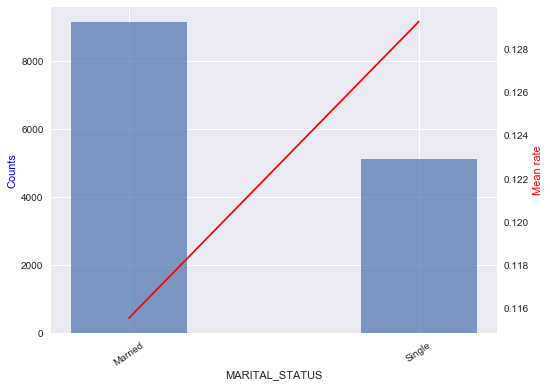

IV:  0.00380333908871


,% responders,% non-responders,WOE,DG-DB,IV
Married,0.614535,0.644313,-0.047320,-0.029779,0.001409
Single,0.385465,0.355687,0.080401,0.029779,0.002394


In [74]:
functions.feature_stat(data, 'MARITAL_STATUS', 'TARGET')
functions.calc_iv(data, 'TARGET', 'MARITAL_STATUS')[0]

## GEN_INDUSTRY

In [75]:
data['GEN_INDUSTRY'].value_counts(dropna=False, normalize=True)

Market, real estate               0.157957
Others fields                     0.113477
Iron & Steel                      0.089451
Unknown                           0.086579
Public  & municipal administ.     0.084477
Healthcare                        0.077683
Schools                           0.064164
Transportation                    0.051695
Agriculture                       0.046372
Construction - Raw Materials      0.037896
Municipal economy/Road service    0.035724
Restaurant & Catering             0.027249
Scientific & Technical Instr.     0.026898
Oil & Gas Operations              0.014780
Assembly production               0.011418
Regional Banks                    0.010857
Recreational Activities           0.009526
Detective                         0.009316
Oil Well Services & Equipment     0.009316
Information service               0.006795
Beauty shop                       0.006514
Software & Programming            0.005534
Chemistry/Perfumery/Pharmaceut    0.004273
Mass media 

In [76]:
data['GEN_INDUSTRY'].cat.add_categories(['others'], inplace=True)
data.loc[data['GEN_INDUSTRY'].isin(['Market, real estate', 'Others fields', 'Iron & Steel', 'Unknown', 'Transportation',
                                   'Public  & municipal administ.', 'Healthcare', 'Schools']) == False,
         'GEN_INDUSTRY'] = 'others'
data['GEN_INDUSTRY'] = data['GEN_INDUSTRY'].cat.remove_unused_categories()

Counts:
GEN_INDUSTRY
Healthcare                       1109
Iron & Steel                     1277
Market, real estate              2255
Others fields                    1620
Public  & municipal administ.    1206
Schools                           916
Transportation                    738
Unknown                          1236
others                           3919
Name: TARGET, dtype: int64
Frequencies:
others                           0.274517
Market, real estate              0.157957
Others fields                    0.113477
Iron & Steel                     0.089451
Unknown                          0.086579
Public  & municipal administ.    0.084477
Healthcare                       0.077683
Schools                          0.064164
Transportation                   0.051695
Name: GEN_INDUSTRY, dtype: float64


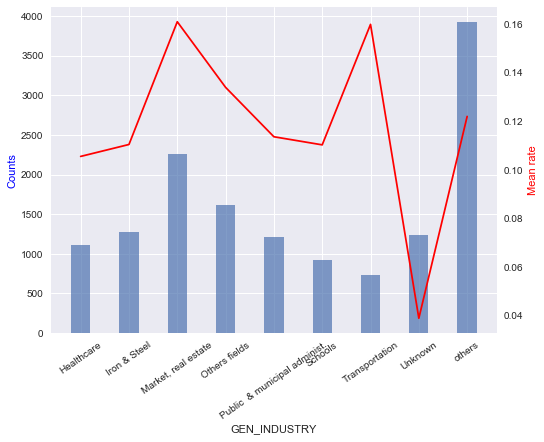

IV:  0.113378430613


,% responders,% non-responders,WOE,DG-DB,IV
"Market, real estate",0.211047,0.150685,0.336887,0.060362,0.020335
others,0.277907,0.274052,0.013968,0.003855,0.000054
Schools,0.058721,0.064909,-0.100193,-0.006188,0.000620
Public & municipal administ.,0.079651,0.085139,-0.066624,-0.005487,0.000366
Others fields,0.126163,0.111739,0.121404,0.014423,0.001751
Iron & Steel,0.081977,0.090475,-0.098634,-0.008498,0.000838
Unknown,0.027907,0.094616,-1.220951,-0.066709,0.081449
Transportation,0.068605,0.049379,0.328839,0.019226,0.006322
Healthcare,0.068023,0.079006,-0.149675,-0.010983,0.001644


In [77]:
functions.feature_stat(data, 'GEN_INDUSTRY', 'TARGET')
functions.calc_iv(data, 'TARGET', 'GEN_INDUSTRY')[0]

## FAMILY_INCOME

In [78]:
data['FAMILY_INCOME'].value_counts(dropna=False, normalize=True)

10000-20000    0.471070
20000-50000    0.405015
5000-10000     0.096526
50000+         0.025077
up to 5000     0.002312
Name: FAMILY_INCOME, dtype: float64

In [79]:
data['FAMILY_INCOME'].cat.add_categories(['up to 10000', '20000+'], inplace=True)
data.loc[data['FAMILY_INCOME'].isin(['up to 5000', '5000-10000']), 'FAMILY_INCOME'] = 'up to 10000'
data.loc[data['FAMILY_INCOME'].isin(['20000-50000', '50000+']), 'FAMILY_INCOME'] = '20000+'
data['FAMILY_INCOME'] = data['FAMILY_INCOME'].cat.remove_unused_categories()

Counts:
FAMILY_INCOME
10000-20000    6725
up to 10000    1411
20000+         6140
Name: TARGET, dtype: int64
Frequencies:
10000-20000    0.471070
20000+         0.430092
up to 10000    0.098837
Name: FAMILY_INCOME, dtype: float64


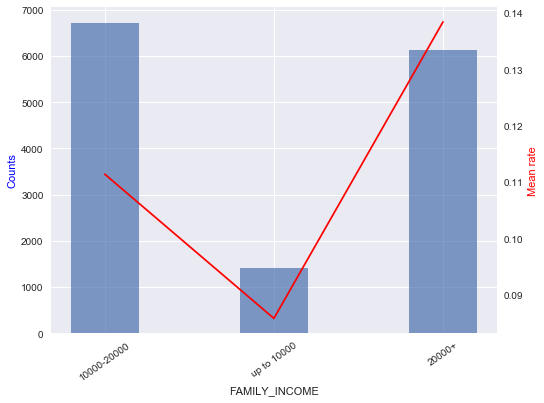

IV:  0.0274921611768


,% responders,% non-responders,WOE,DG-DB,IV
10000-20000,0.435465,0.475948,-0.088893,-0.040483,0.003599
20000+,0.494186,0.421313,0.159537,0.072874,0.011626
up to 10000,0.070349,0.102740,-0.378733,-0.032391,0.012267


In [80]:
functions.feature_stat(data, 'FAMILY_INCOME', 'TARGET')
functions.calc_iv(data, 'TARGET', 'FAMILY_INCOME')[0]

## LOAN_NUM_TOTAL

In [81]:
data['LOAN_NUM_TOTAL'].value_counts(dropna=False, normalize=True)

1     0.738232
2     0.174489
3     0.058350
4     0.018282
5     0.007005
6     0.002452
7     0.000981
8     0.000140
11    0.000070
Name: LOAN_NUM_TOTAL, dtype: float64

In [82]:
data['LOAN_NUM_TOTAL'].cat.add_categories(['3 or more'], inplace=True)
data.loc[data['LOAN_NUM_TOTAL'].isin([1, 2]) == False, 'LOAN_NUM_TOTAL'] = '3 or more'
data['LOAN_NUM_TOTAL'] = data['LOAN_NUM_TOTAL'].cat.remove_unused_categories()

Counts:
LOAN_NUM_TOTAL
1            10539
2             2491
3 or more     1246
Name: TARGET, dtype: int64
Frequencies:
1            0.738232
2            0.174489
3 or more    0.087279
Name: LOAN_NUM_TOTAL, dtype: float64


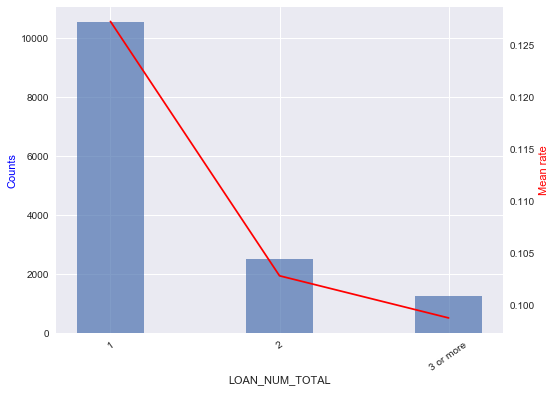

IV:  0.0121634889441


,% responders,% non-responders,WOE,DG-DB,IV
1,0.779651,0.732558,0.062304,0.047093,0.002934
2,0.148837,0.178003,-0.178945,-0.029165,0.005219
3 or more,0.071512,0.089439,-0.223700,-0.017928,0.004010


In [83]:
functions.feature_stat(data, 'LOAN_NUM_TOTAL', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_NUM_TOTAL')[0]

## LOAN_NUM_TOTAL

In [84]:
data['LOAN_NUM_CLOSED'].value_counts(dropna=False, normalize=True)

0     0.522275
1     0.302045
2     0.115999
3     0.039857
4     0.013379
5     0.004133
6     0.001821
7     0.000280
8     0.000140
11    0.000070
Name: LOAN_NUM_CLOSED, dtype: float64

In [85]:
data['LOAN_NUM_CLOSED'].cat.add_categories(['3 or more'], inplace=True)
data.loc[data['LOAN_NUM_CLOSED'].isin([0, 1, 2]) == False, 'LOAN_NUM_CLOSED'] = '3 or more'
data['LOAN_NUM_CLOSED'] = data['LOAN_NUM_CLOSED'].cat.remove_unused_categories()

Counts:
LOAN_NUM_CLOSED
0            7456
1            4312
2            1656
3 or more     852
Name: TARGET, dtype: int64
Frequencies:
0            0.522275
1            0.302045
2            0.115999
3 or more    0.059681
Name: LOAN_NUM_CLOSED, dtype: float64


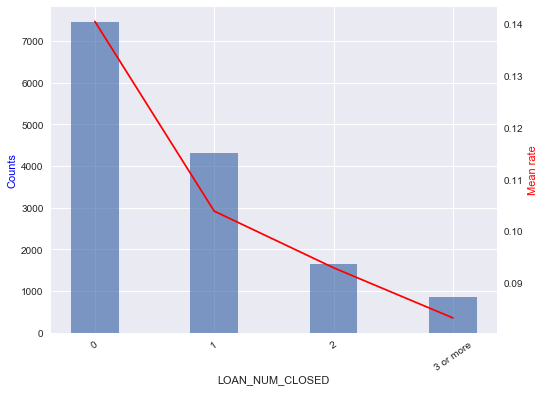

IV:  0.0424898763872


,% responders,% non-responders,WOE,DG-DB,IV
1,0.260465,0.307741,-0.166791,-0.047276,0.007885
2,0.089535,0.119624,-0.289726,-0.030089,0.008718
0,0.608721,0.510433,0.176100,0.098288,0.017308
3 or more,0.041279,0.062201,-0.410021,-0.020922,0.008579


In [86]:
functions.feature_stat(data, 'LOAN_NUM_CLOSED', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_NUM_CLOSED')[0]

## LOAN_DLQ_NUM

In [87]:
data['LOAN_DLQ_NUM'].value_counts(dropna=False, normalize=True)

0     0.871603
1     0.094284
2     0.018633
3     0.006514
4     0.003362
5     0.002662
6     0.001121
7     0.000911
9     0.000280
8     0.000210
13    0.000140
10    0.000140
12    0.000070
11    0.000070
Name: LOAN_DLQ_NUM, dtype: float64

In [88]:
data['LOAN_DLQ_NUM'].cat.add_categories(['1 or more'], inplace=True)
data.loc[data['LOAN_DLQ_NUM'].isin([0]) == False, 'LOAN_DLQ_NUM'] = '1 or more'
data['LOAN_DLQ_NUM'] = data['LOAN_DLQ_NUM'].cat.remove_unused_categories()

Counts:
LOAN_DLQ_NUM
0            12443
1 or more     1833
Name: TARGET, dtype: int64
Frequencies:
0            0.871603
1 or more    0.128397
Name: LOAN_DLQ_NUM, dtype: float64


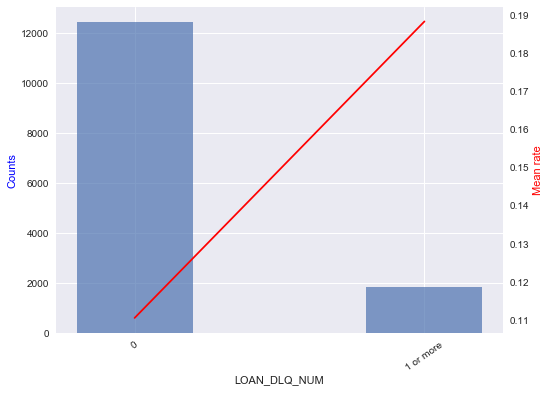

IV:  0.0512098860054


,% responders,% non-responders,WOE,DG-DB,IV
1 or more,0.200581,0.118509,0.526231,0.082072,0.043189
0,0.799419,0.881491,-0.097730,-0.082072,0.008021


In [89]:
functions.feature_stat(data, 'LOAN_DLQ_NUM', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_DLQ_NUM')[0]

## LOAN_MAX_DLQ

In [90]:
data['LOAN_MAX_DLQ'].value_counts(dropna=False, normalize=True)

0    0.871603
1    0.125525
2    0.002171
3    0.000490
8    0.000070
6    0.000070
4    0.000070
Name: LOAN_MAX_DLQ, dtype: float64

In [91]:
data['LOAN_MAX_DLQ'].cat.add_categories(['1 or more'], inplace=True)
data.loc[data['LOAN_MAX_DLQ'].isin([0]) == False, 'LOAN_MAX_DLQ'] = '1 or more'
data['LOAN_MAX_DLQ'] = data['LOAN_MAX_DLQ'].cat.remove_unused_categories()

Counts:
LOAN_MAX_DLQ
0            12443
1 or more     1833
Name: TARGET, dtype: int64
Frequencies:
0            0.871603
1 or more    0.128397
Name: LOAN_MAX_DLQ, dtype: float64


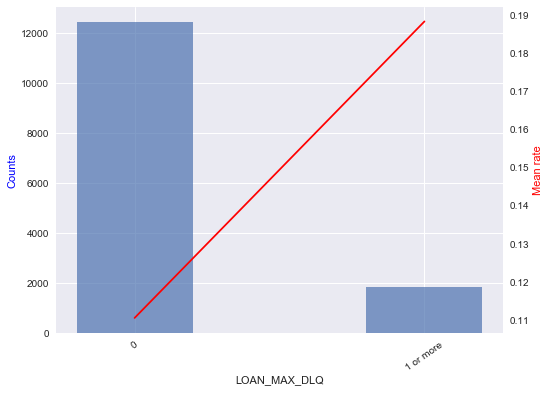

IV:  0.0512098860054


,% responders,% non-responders,WOE,DG-DB,IV
1 or more,0.200581,0.118509,0.526231,0.082072,0.043189
0,0.799419,0.881491,-0.097730,-0.082072,0.008021


In [92]:
functions.feature_stat(data, 'LOAN_MAX_DLQ', 'TARGET')
functions.calc_iv(data, 'TARGET', 'LOAN_MAX_DLQ')[0]

In [93]:
data.head(10)

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,FAMILY_INCOME,PERSONAL_INCOME,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,Income_to_limit
1,59910230,0,"(30.0, 34.0]",1,0,1,3 or more,2 or more,Some High School,Married,"Market, real estate",10000-20000,"(11000.0, 14800.0]",1,1,1,0,0,0,0,0,"(18100.0, 22500.0]","(4.5, 8.5]","(3800.0, 6000.0]",1,"(131.5, 171.5]","(85.5, 151.0]",1,0,1,1,1,"(5.5, 6.5]",1 or more,1 or more,"(500.0, 15000.0]","(500.0, 15000.0]","(0.515, 0.783]"
2,59910525,0,"(50.0, 54.0]",1,0,1,3 or more,2 or more,Some High School,Married,others,10000-20000,"(7600.0, 9300.0]",1,1,1,1,0,0,0,1,"(22500.0, 119700.0]","(11.5, 36.0]","(3800.0, 6000.0]",1,"(238.5, 1000.0]","(53.5, 85.5]",0,0,1,2,1,"(6.5, 11.5]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(0.0, 0.515]"
3,59910803,0,"(38.0, 42.0]",1,0,1,1,1,Undergraduate Degree,Married,Schools,20000+,"(20800.0, 44000.0]",0,0,0,1,1,0,0,0,"(7200.0, 9400.0]","(4.5, 8.5]","(3800.0, 6000.0]",0,"(18.5, 38.5]","(151.0, 600.0]",1,1,1,1,1,"(5.5, 6.5]",1 or more,1 or more,"(500.0, 15000.0]","(500.0, 15000.0]","(2.556, 16.706]"
4,59911781,0,"(26.0, 30.0]",1,0,0,0,2 or more,Some High School,Married,Public & municipal administ.,10000-20000,"(11000.0, 14800.0]",1,1,1,0,0,0,0,1,"(18100.0, 22500.0]","(11.5, 36.0]","(3800.0, 6000.0]",1,"(38.5, 85.5]","(85.5, 151.0]",1,0,1,2,1,"(11.5, 110.0]",1 or more,1 or more,"(500.0, 15000.0]","(500.0, 15000.0]","(0.515, 0.783]"
5,59911784,0,"(26.0, 30.0]",1,0,0,0,2 or more,Some High School,Married,"Market, real estate",20000+,"(11000.0, 14800.0]",1,1,1,1,0,1,0,0,"(22500.0, 119700.0]","(11.5, 36.0]","(2100.0, 3800.0]",0,"(85.5, 131.5]","(35.5, 53.5]",1,0,1,2,1,"(6.5, 11.5]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(0.0, 0.515]"
7,59912034,0,"(38.0, 42.0]",1,0,1,0,2 or more,Some High School,Married,others,10000-20000,"(0.0, 7600.0]",1,1,1,1,1,0,0,0,"(14100.0, 18100.0]","(8.5, 11.5]","(200.0, 900.0]",1,"(171.5, 238.5]","(0.0, 6.5]",1,1,1,2,1,"(6.5, 11.5]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(0.0, 0.515]"
9,59912659,0,"(42.0, 50.0]",1,0,1,0,2 or more,Professional School,Married,Schools,10000-20000,"(0.0, 7600.0]",1,1,1,1,1,0,0,0,"(0.0, 5400.0]","(4.5, 8.5]","(200.0, 900.0]",0,"(238.5, 1000.0]","(53.5, 85.5]",0,0,1,1,1,"(5.5, 6.5]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(1.428, 1.962]"
10,59912692,0,"(50.0, 54.0]",1,0,1,2,2 or more,Professional School,Single,Schools,20000+,"(15300.0, 20800.0]",1,1,1,1,1,0,0,0,"(0.0, 5400.0]","(0.0, 4.5]","(200.0, 900.0]",0,"(238.5, 1000.0]","(85.5, 151.0]",1,0,1,1,1,"(0.0, 3.5]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(2.556, 16.706]"
11,59913108,1,"(0.0, 26.0]",1,0,0,0,2 or more,Professional School,Single,Others fields,10000-20000,"(15300.0, 20800.0]",1,1,1,1,0,0,0,0,"(9400.0, 14100.0]","(0.0, 4.5]","(6000.0, 75600.0]",1,"(38.5, 85.5]","(21.5, 35.5]",0,0,1,2,1,"(11.5, 110.0]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(1.428, 1.962]"
12,59913134,1,"(54.0, 67.0]",0,1,0,3 or more,2 or more,Some High School,Married,Iron & Steel,10000-20000,"(0.0, 7600.0]",1,1,1,1,0,1,1,0,"(9400.0, 14100.0]","(0.0, 4.5]","(2100.0, 3800.0]",1,"(238.5, 1000.0]","(35.5, 53.5]",0,0,1,1,1,"(0.0, 3.5]",0,0,"(0.0, 500.0]","(0.0, 500.0]","(0.515, 0.783]"


This is it, all the variables are transformed. I didn't do anything to several variables which are flags, but they are good as they are.

# Feature selection based on IV

Now it is time to choose columns. It could be done before, while processing separate columns, but I prefer to do this for all columns at once. I calculate IV for all columns and use only those which have value higher that threshold (0.02 in this case).

In [94]:
columns_to_try = [col for col in list(data.columns) if col not in ('AGREEMENT_RK', 'CARD_ID_SB8', 'CARD_NUM', 'TARGET')]

In [95]:
ivs = []
for col in columns_to_try:
    data[col] = data[col].astype('category')
    if data[col].isnull().any():
        print(col)
        if 'Unknown' not in data[col].cat.categories:
            data[col].cat.add_categories(['Unknown'], inplace=True)
        data[col].fillna('Unknown', inplace=True)
    data[col] = data[col].cat.remove_unused_categories()
    _, iv = functions.calc_iv(data, 'TARGET', col)
    ivs.append((col, np.round(iv, 4)))

In [96]:
good_cols = [i[0] for i in sorted(ivs, key=lambda tup: tup[1], reverse=True) if i[1] > 0.02]
for i in ['TARGET', 'AGREEMENT_RK']:
    good_cols.append(i)

In [97]:
good_cols

['AGE',
 'GEN_INDUSTRY',
 'WORK_TIME',
 'PERSONAL_INCOME',
 'GEN_PHONE_FL',
 'SOCSTATUS_PENS_FL',
 'SOCSTATUS_WORK_FL',
 'LOAN_AVG_DLQ_AMT',
 'LOAN_DLQ_NUM',
 'LOAN_MAX_DLQ',
 'LOAN_MAX_DLQ_AMT',
 'FACT_LIVING_TERM',
 'LOAN_NUM_CLOSED',
 'FST_PAYMENT',
 'TERM',
 'Income_to_limit',
 'LOAN_NUM_PAYM',
 'FAMILY_INCOME',
 'REG_FACT_POST_TP_FL',
 'TARGET',
 'AGREEMENT_RK']

## Some additional visualization

Plotting variables by themselves is useful, but visualizing their interactions can unveil interesting things. There are some examples below.

Pointplots show mean target rate for pairs of variables. I show only several plots as there are too many possible combinations.

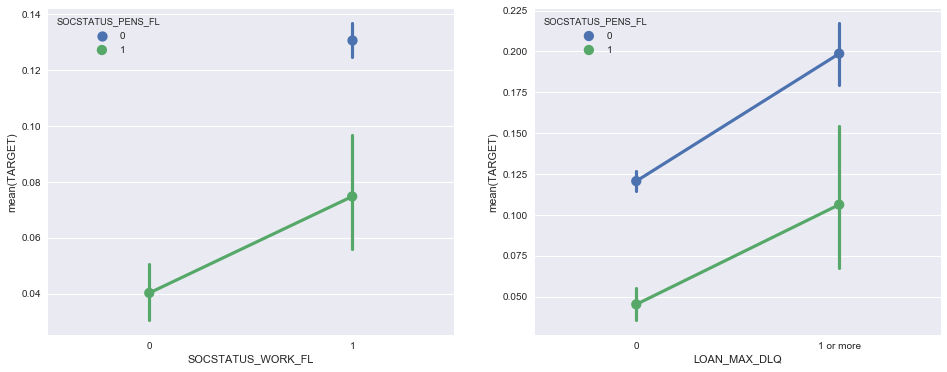

In [98]:
data_viz = data[good_cols]
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
sns.pointplot(x='SOCSTATUS_WORK_FL', y="TARGET", hue='SOCSTATUS_PENS_FL', data=data_viz, ax=ax[0])
sns.pointplot(x='LOAN_MAX_DLQ', y="TARGET", hue='SOCSTATUS_PENS_FL', data=data_viz, ax=ax[1])

SOCSTATUS_PENS_FL 1 means that person is on pension, 0 otherwise.
SOCSTATUS_WORK_FL 1 means that person works, 0 otherwise.

Three features on the plots above show clear distinctions between mean target rates. It could be a good idea to create new variables showing these interactions.

In [99]:
data['work_pens'] = 0
data.loc[data['SOCSTATUS_WORK_FL'] == 0, 'work_pens'] = 1
data.loc[(data['SOCSTATUS_WORK_FL'] == 1) & (data['SOCSTATUS_PENS_FL'] == 1), 'work_pens'] = 2
data.loc[(data['SOCSTATUS_WORK_FL'] == 1) & (data['SOCSTATUS_PENS_FL'] == 0), 'work_pens'] = 3

In [100]:
data['pens_dlq'] = 0
data.loc[(data['LOAN_MAX_DLQ'] == 0) & (data['SOCSTATUS_PENS_FL'] == 0), 'pens_dlq'] = 1
data.loc[(data['LOAN_MAX_DLQ'] == '1 or more') & (data['SOCSTATUS_PENS_FL'] == 1), 'pens_dlq'] = 2
data.loc[(data['LOAN_MAX_DLQ'] == 0) & (data['SOCSTATUS_PENS_FL'] == 0), 'pens_dlq'] = 3
data.loc[(data['LOAN_MAX_DLQ'] == '1 or more') & (data['SOCSTATUS_PENS_FL'] == 1), 'pens_dlq'] = 4

For the next graphs I'll need data, where continuous variables aren't binned. Also it is necessary to do label encoding for categorical variables, as sns.pairplot doesn't work well with them.

In [101]:
le = preprocessing.LabelEncoder()
for col in ['GENDER', 'CHILD_TOTAL', 'DEPENDANTS', 'EDUCATION', 'MARITAL_STATUS', 'GEN_INDUSTRY', 'OWN_AUTO',
            'FAMILY_INCOME', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM', 'LOAN_MAX_DLQ']:
    initial_data[col] = initial_data[col].astype('category')
    if (initial_data[col].isnull() == True).any():
        initial_data[col].cat.add_categories(['Unknown'], inplace=True)
        initial_data[col].fillna('Unknown', inplace=True)
    initial_data[col] = le.fit_transform(initial_data[col])  

In [102]:
data_viz1 = initial_data[good_cols].drop(['AGREEMENT_RK'], axis=1)

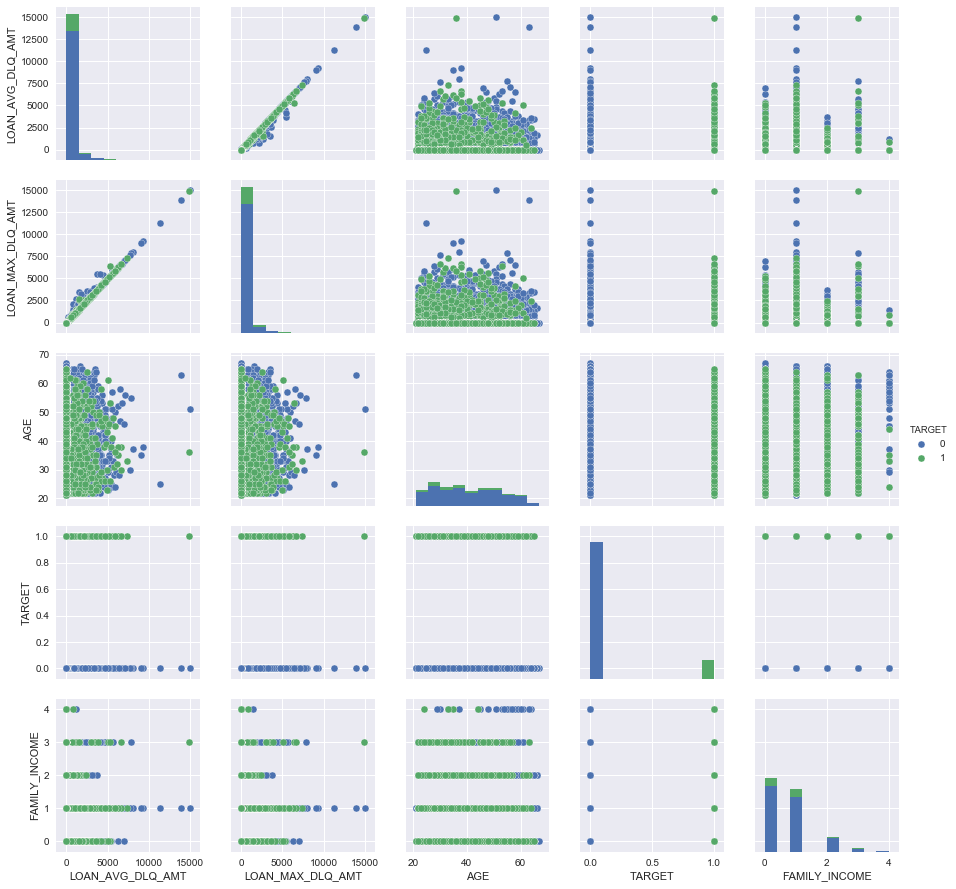

In [103]:
plt.figure(figsize=(32, 32))
sns.pairplot(data_viz1[['LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT', 'AGE', 'TARGET', 'FAMILY_INCOME']], hue='TARGET')

I included only several variables in this pairplot, but it shows how variables can interact. Sometimes variables may interact in such a way, that their values cleate visible clusters based on target. New variables can be created based on this.
Another use of the graph is to find correlated features. 'LOAN_AVG_DLQ_AMT' and 'LOAN_MAX_DLQ_AMT' seem to be highly correlated, let's have a look.

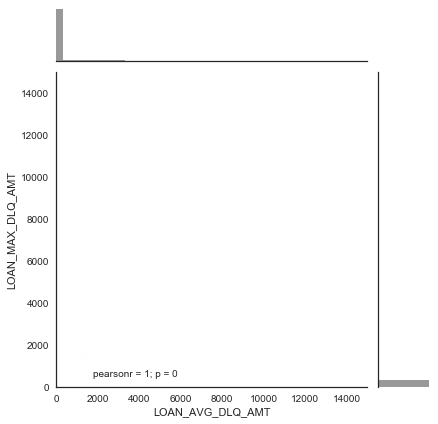

In [104]:
with sns.axes_style("white"):
    sns.jointplot(x=data_viz1['LOAN_AVG_DLQ_AMT'], y=data_viz1['LOAN_MAX_DLQ_AMT'], kind="hex", color="k");

Well, it seems that pearson correlation coefficient is 1 which shows very high correlation. I'll drop one of these columns.

In [105]:
data.drop(['LOAN_AVG_DLQ_AMT'], axis=1, inplace=True)

Let's try selecting variables based on IV again.

In [106]:
columns_to_try = [col for col in list(data.columns) if col not in ('AGREEMENT_RK', 'CARD_ID_SB8', 'CARD_NUM', 'TARGET')]
ivs = []
for col in columns_to_try:
    data[col] = data[col].astype('category')
    if data[col].isnull().any():
        print(col)
        if 'Unknown' not in data[col].cat.categories:
            data[col].cat.add_categories(['Unknown'], inplace=True)
        data[col].fillna('Unknown', inplace=True)
    data[col] = data[col].cat.remove_unused_categories()
    _, iv = functions.calc_iv(data, 'TARGET', col)
    ivs.append((col, np.round(iv, 4)))
good_cols = [i[0] for i in sorted(ivs, key=lambda tup: tup[1], reverse=True) if i[1] > 0.02]
for i in ['TARGET', 'AGREEMENT_RK']:
    good_cols.append(i)
good_cols

['AGE',
 'GEN_INDUSTRY',
 'work_pens',
 'WORK_TIME',
 'PERSONAL_INCOME',
 'GEN_PHONE_FL',
 'SOCSTATUS_PENS_FL',
 'SOCSTATUS_WORK_FL',
 'LOAN_DLQ_NUM',
 'LOAN_MAX_DLQ',
 'LOAN_MAX_DLQ_AMT',
 'FACT_LIVING_TERM',
 'LOAN_NUM_CLOSED',
 'FST_PAYMENT',
 'TERM',
 'Income_to_limit',
 'LOAN_NUM_PAYM',
 'FAMILY_INCOME',
 'REG_FACT_POST_TP_FL',
 'TARGET',
 'AGREEMENT_RK']

One of the newly created features proved to be useful! Now it's time to go further. I'll dummify all features.

In [107]:
columns_dummify = [col for col in good_cols if col not in ('TARGET', 'AGREEMENT_RK')]
data = data[good_cols]
for col in columns_dummify:
    data[col] = data[col].astype('category')
    dummies = pd.get_dummies(data[col])
    dummies = dummies.add_prefix('{}_:_'.format(col))
    data.drop([col], axis=1, inplace=True)
    data = data.join(dummies)

In [108]:
X = data.drop(['TARGET', 'AGREEMENT_RK'], axis=1)
Y = data['TARGET']

In [109]:
X.shape

(14276, 87)

87 variables could be okay, but I think it could be a good idea to reduce the number of them. There are various ways to select features: greedy algorithms, feature importance and so on. As I'm going to use Logistic Regression, I'll use sklearn's RandomizedLogisticRegression for this.

[RandomizedLogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLogisticRegression.html) basically runs Logistic Regression several times with various penalties for random coefficients. After the runs high scores are assigned to the most stable features.

In [110]:
randomized_logistic = linear_model.RandomizedLogisticRegression(C=0.1, selection_threshold=0.5,
                                                                n_resampling=50, normalize=False)
X_train_log = randomized_logistic.fit_transform(X=X, y=Y)
randomized_logistic.get_support()

array([ True, False, False, False,  True,  True, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False,  True,  True, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
        True, False,  True, False, False,  True, False, False, False,
        True, False, False, False,  True,  True], dtype=bool)

In [111]:
X_train_log.shape

(14276, 36)

36 from 87 were selected. It's time for the model. I split data into train, test and validation sets. LogisticRegressionCV is used to choose an optimal regularization strength.

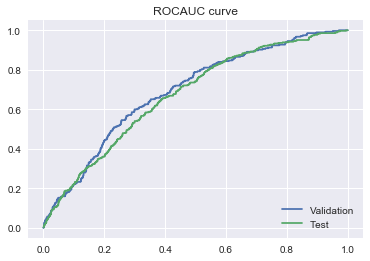

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_train_log, Y, test_size=0.2, stratify = Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train)
logreg = linear_model.LogisticRegressionCV(class_weight='balanced', n_jobs=-1, fit_intercept=True)
logreg.fit(X_train, y_train)

y_pred_log_val = logreg.predict_proba(X_val)
y_pred_log_val_1 = [i[1] for i in y_pred_log_val]
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_log_val_1)
plt.plot(fpr_val, tpr_val, label='Validation')
scores_val = cross_val_score(logreg, X_val, y_val, cv=5, scoring='roc_auc')

y_pred_log_test = logreg.predict_proba(X_test)
y_pred_log_test_1 = [i[1] for i in y_pred_log_test]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_log_test_1)
plt.plot(fpr_test, tpr_test, label='Test')
scores_test = cross_val_score(logreg, X_test, y_test, cv=5, scoring='roc_auc')

plt.title('ROCAUC curve')
plt.legend(loc='lower right')

In [113]:
print('Validation auc: ', np.round(auc(fpr_val, tpr_val), 4))
print('Cross-validation: mean value is {0} with std {1}.'.format(np.round(np.mean(scores_val), 4),
                                                                 np.round(np.std(scores_val), 4)))
print('Test auc: ', np.round(auc(fpr_test, tpr_test), 4))
print('Cross-validation: mean value is {0} with std {1}.'.format(np.round(np.mean(scores_test), 4),
                                                                 np.round(np.std(scores_test), 4)))

Validation auc:  0.6906
Cross-validation: mean value is 0.6612 with std 0.023.
Test auc:  0.6728
Cross-validation: mean value is 0.6593 with std 0.0308.


In [114]:
coefs = pd.DataFrame(list(zip(X[X.columns[randomized_logistic.get_support()]].columns, logreg.coef_[0])),
             columns=['Feature', 'Coefficient'])
coefs

,Feature,Coefficient
0,"AGE_:_(0.0, 26.0]",0.058152
1,"AGE_:_(38.0, 42.0]",0.326568
2,"AGE_:_(42.0, 50.0]",-0.049522
3,"AGE_:_(54.0, 67.0]",-0.384079
4,"GEN_INDUSTRY_:_Market, real estate",0.179091
5,work_pens_:_3,0.515434
6,"WORK_TIME_:_(6.5, 21.5]",0.288714
7,"WORK_TIME_:_(35.5, 53.5]",0.168606
8,"WORK_TIME_:_(85.5, 151.0]",-0.168910
9,"WORK_TIME_:_(151.0, 600.0]",-0.381151


And here we can see how each category influenced the result.

So, this is it. The score is quite high, accuracy on real test set should be lower, but hopefully not much. There are many ways to enchance the model, of course:
- Transform variables with more care - maybe change parameters for DecisionTreeClassifier for specific variables to create better bins;
- Fill missing values with something else;
- Treat outliers instead of dropping rows with them;
- Create more variables bases of feature interaction;
- Try different threshold for feature selection);

And if interpreting variables isn't necessary, then continuous variables can be used without binning. Maybe they can be transformed some way or scaled. More sophisticated algorithms can be used such as a reputable xgboost and so on.